In [1]:
import os, sys, math, random, argparse
import numpy as np
import matplotlib.pyplot as plt

path = os.getcwd()
random.seed(100)

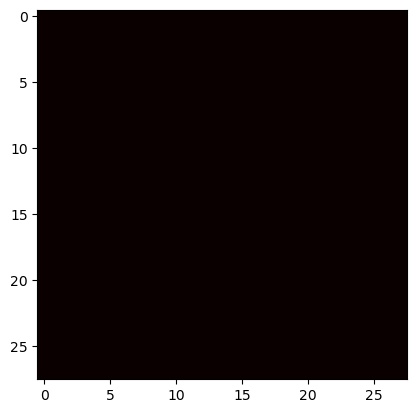

In [28]:
# hicplus
z = np.load('/data/HiHiC-main/output/SRHiC_predict_16.npz', allow_pickle=True)

z.files
z['data'].shape #(3952, 28, 28, 1)
z['data'][0,:,:,0].shape # (28, 28)
# z[:,:,:40].shape
plt.imshow(z['data'][0,:,:,0], cmap='hot')

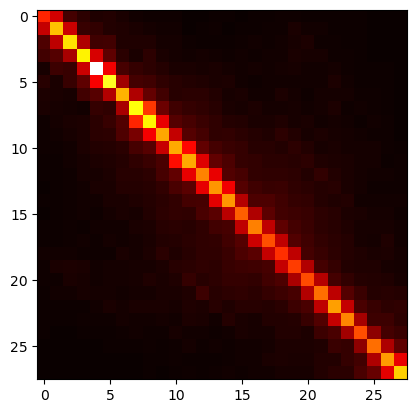

In [35]:
# deepHiC test
x = np.load("/data/HiHiC-main/output/hicplus_predict_16.npz")
x.files # ['data', 'inds']
x['data'].shape
plt.imshow(x['data'][0,0], cmap='hot')

In [37]:
x['data'].shape

(2076, 1, 28, 28)

In [29]:
# deepHiC test
x = np.load("/data/HiHiC-main/data_DeepHiC/test/test_ratio16.npz")
x.files # ['data', 'target', 'inds', 'compacts', 'size']
# x['data'][0,0].shape
# plt.imshow(x['target'][0,0], cmap='hot')

['data', 'target', 'inds', 'compacts', 'sizes']

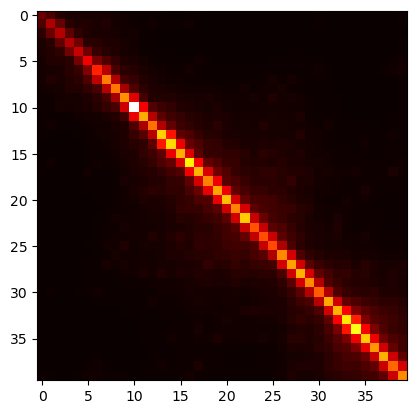

In [31]:
# deepHiC prediction
z = np.load("/data/HiHiC-main/output/HiCARN_predict_chr18_16.npz")
# z.files # ['data', 'inds']
plt.imshow(z['data'][0,0], cmap='hot')

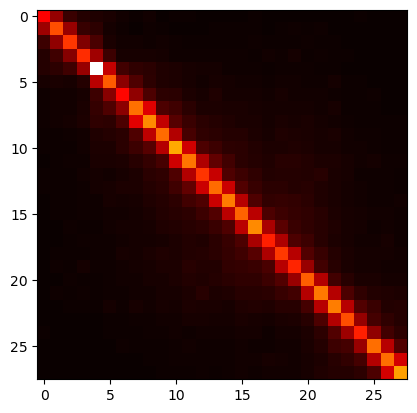

In [34]:
# SRHiC prediction
z = np.load("/data/HiHiC-main/output/HiCNN2_predict_16.npz")
z['data'].shape
plt.imshow(z['data'][0,0], cmap='hot')

In [18]:
z['data'][1,:,:,0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0

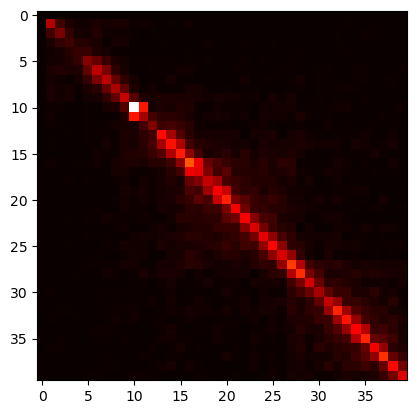

In [45]:
x = np.load("/data/HiHiC-main/data_DFHiC/test/test_ratio16.npz")
x.files # ['data', 'target', 'inds', 'compacts', 'size']
plt.imshow(x['target'][0,:,:,0], cmap='hot')

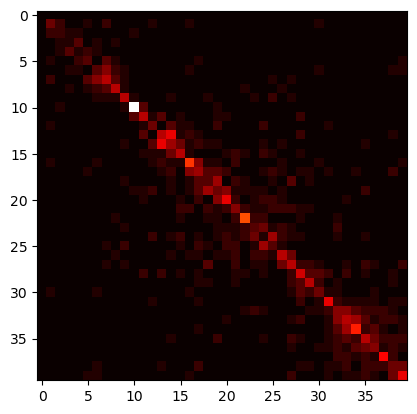

In [44]:
x = np.load("/data/HiHiC-main/data_DFHiC/test/test_ratio16.npz")
x.files # ['data', 'target', 'inds', 'compacts', 'size']
plt.imshow(x['data'][0,:,:,0], cmap='hot')

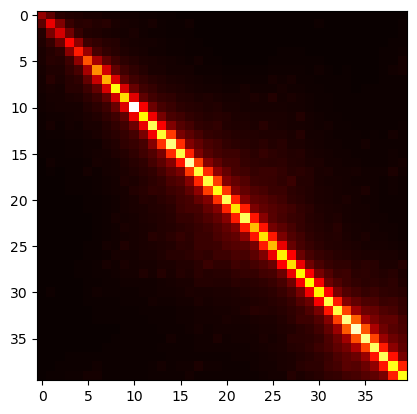

In [22]:
# DFHiC prediction
z = np.load("/data/HiHiC-main/output/DFHiC_predicted_16.npz")
z.files # ['arr_0']
plt.imshow(z['arr_0'][0,:,:,0], cmap='hot')

(33197, 1, 40, 40)

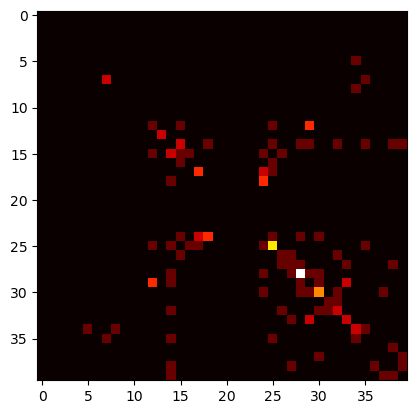

In [170]:
# HiCNN
z = np.load('/data/HiHiC-main/data_HiCNN/subMats_train_ratio16.npy')
plt.imshow(z[0,0], cmap='hot')
z.shape

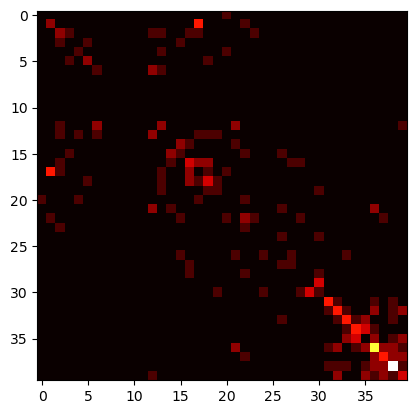

In [163]:
# hicplus
z = np.load('/data/HiHiC-main/data_hicplus/subMats_train_ratio16.npy')
plt.imshow(z[0,0], cmap='hot')

(35295, 40, 68)

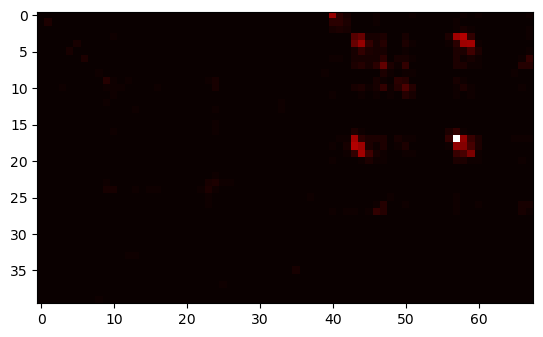

In [169]:
# SRHiC
z = np.load('/data/HiHiC-main/data_SRHiC/train/train_data_raw_ratio16.npy')
plt.imshow(z[0], cmap='hot')
z.shape

loss trend

In [39]:
np.load('/data/HiHiC-main/log/train_loss_hicplus.npy')

array([['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100',
        '110', '120', '130', '140', '150', '160', '170', '180', '190',
        '200', '210', '220', '230', '240', '250', '260', '270', '280',
        '290', '300', '310', '320', '330', '340', '350', '360', '370',
        '380', '390', '400', '410', '420', '430', '440', '450', '460',
        '470', '480', '490'],
       ['0.00.07', '0.00.11', '0.00.15', '0.00.19', '0.00.22', '0.00.26',
        '0.00.29', '0.00.33', '0.00.36', '0.00.40', '0.00.43', '0.00.47',
        '0.00.50', '0.00.54', '0.00.57', '0.01.01', '0.01.04', '0.01.08',
        '0.01.11', '0.01.15', '0.01.19', '0.01.22', '0.01.26', '0.01.29',
        '0.01.33', '0.01.36', '0.01.40', '0.01.43', '0.01.47', '0.01.50',
        '0.01.54', '0.01.57', '0.02.01', '0.02.04', '0.02.08', '0.02.11',
        '0.02.15', '0.02.18', '0.02.22', '0.02.25', '0.02.29', '0.02.32',
        '0.02.36', '0.02.39', '0.02.43', '0.02.46', '0.02.50', '0.02.53',
        '0.02.57', '

In [7]:
np.load('/data/HiHiC-main/log/train_loss_HiCNN2.npy')

array([['10', '20', '30', '40', '50', '60', '70', '80', '90', '100',
        '110', '120', '130', '140', '150', '160', '170', '180', '190',
        '200', '210', '220', '230', '240', '250', '260', '270', '280',
        '290', '300', '310', '320', '330', '340', '350', '360', '370',
        '380', '390', '400', '410', '420', '430', '440', '450', '460',
        '470', '480', '490', '500'],
       ['0.13.33', '0.26.57', '0.40.22', '0.53.46', '1.07.11', '1.20.35',
        '1.34.00', '1.47.25', '2.00.49', '2.14.14', '2.27.38', '2.41.03',
        '2.54.27', '3.07.52', '3.21.17', '3.34.41', '3.48.06', '4.01.30',
        '4.14.55', '4.28.19', '4.41.44', '4.55.08', '5.08.33', '5.21.58',
        '5.35.22', '5.48.47', '6.02.11', '6.15.36', '6.29.00', '6.42.25',
        '6.55.50', '7.09.14', '7.22.39', '7.36.03', '7.49.28', '8.02.52',
        '8.16.17', '8.29.41', '8.43.06', '8.56.31', '9.09.55', '9.23.20',
        '9.36.44', '9.50.09', '10.03.34', '10.16.58', '10.30.23',
        '10.43.47', '10.57

In [3]:
os.listdir('/data/HiHiC-main/log')

['train_loss_HiCNN2.npy',
 'train_loss_DeepHiC.npy',
 'train_loss_HiCARN1.npy',
 'train_loss_DFHiC.npy',
 'train_loss_SRHiC.npy',
 'train_loss_hicplus.npy']

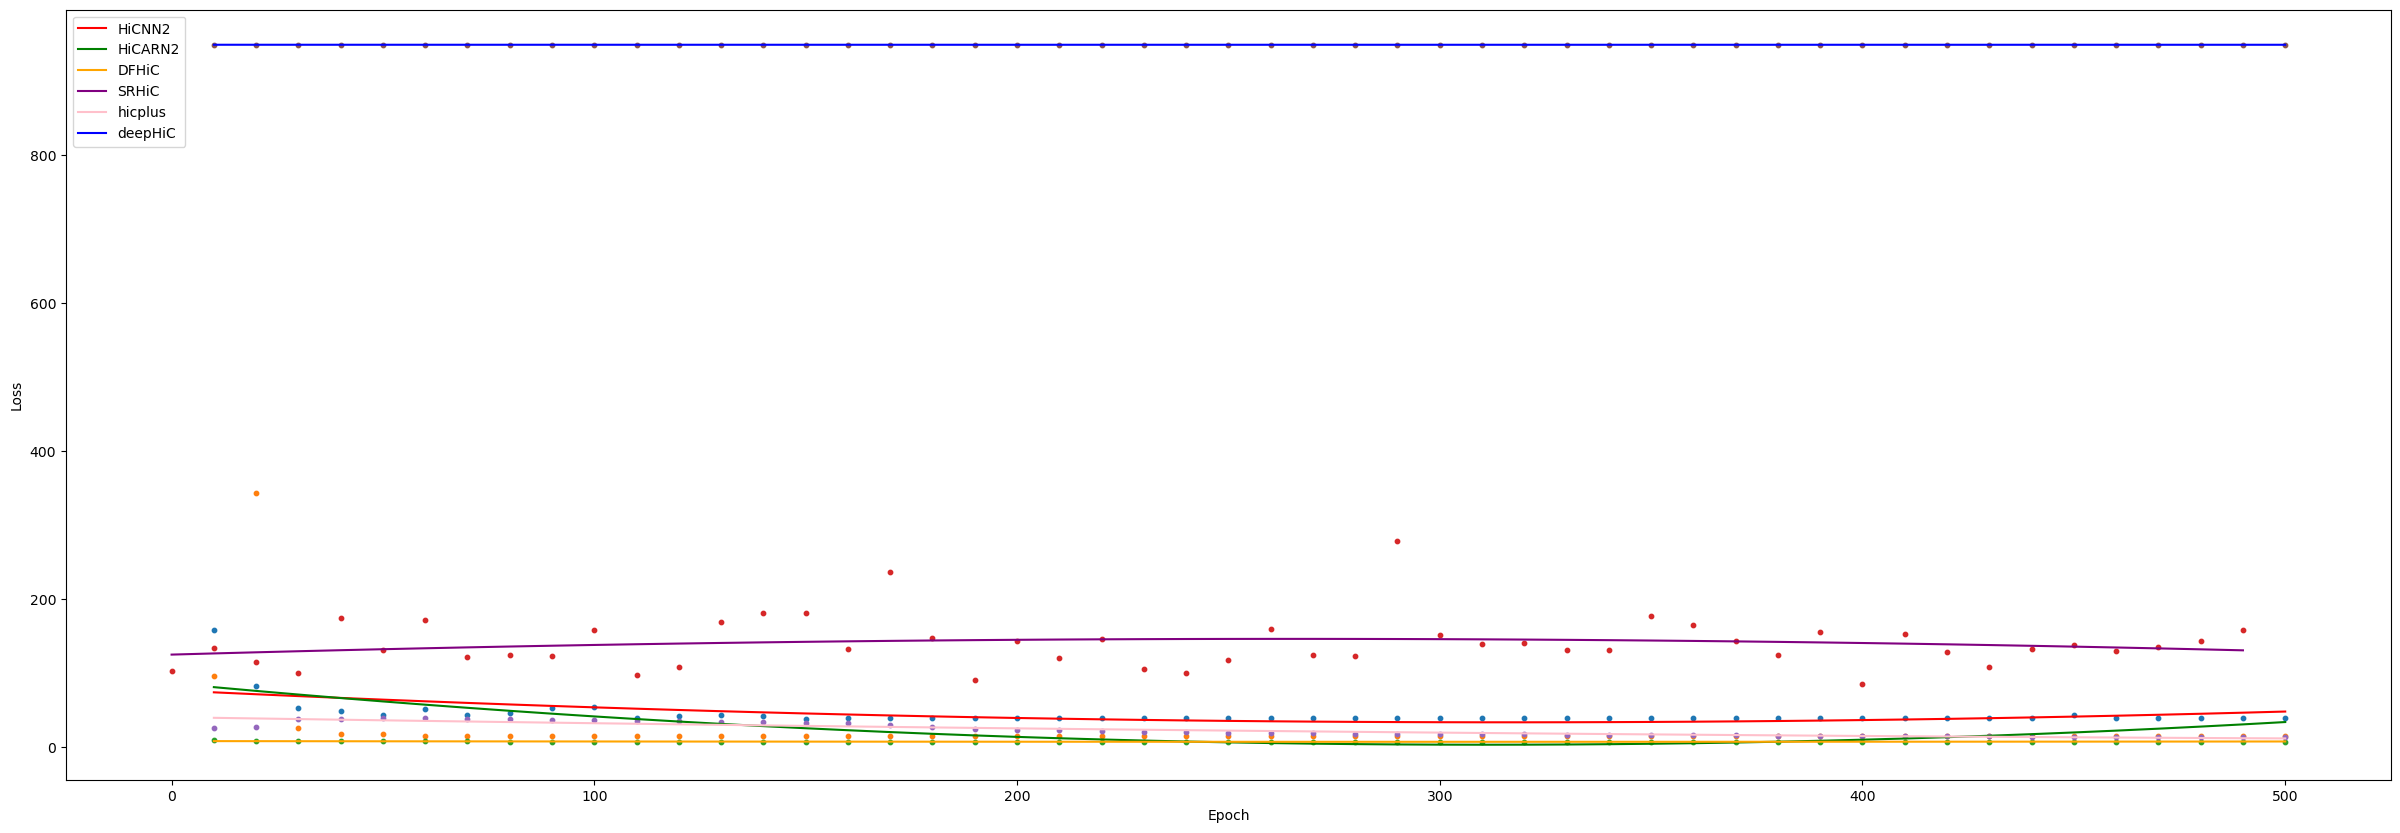

In [2]:
plt.figure(figsize=(30,10))

for i, c, l in zip(['/data/HiHiC-main/log/train_loss_HiCNN2.npy',
                    '/data/HiHiC-main/log/train_loss_HiCARN2.npy',
                    '/data/HiHiC-main/log/train_loss_DFHiC.npy',
                    '/data/HiHiC-main/log/train_loss_SRHiC.npy',
                    '/data/HiHiC-main/log/train_loss_hicplus.npy',
                    '/data/HiHiC-main/log/train_loss_DeepHiC.npy'],
                    ['red', 'green', 'orange', 'purple', 'pink', 'blue'],
                    ['HiCNN2', 'HiCARN2', 'DFHiC', 'SRHiC', 'hicplus', 'deepHiC']):
    i = np.load(i)
    x = i[0][:50].astype(np.int32)
    y = i[2][:50].astype(np.float32)
    plt.scatter(x,y, s=10)
    z = np.polyfit(x,y, 2)
    p = np.poly1d(z)
    plt.plot(x, p(x), color=c, label=l)
    # for i, (xx, yy, time) in enumerate(zip(x, y, i[1][:50])):
    #     if i%8 ==0:
    #         plt.text(xx, yy, time.replace('.','h', 1).replace('.', 'm', 1)+'s')
# plt.ylim([0.39, 0.42]) # [0.39, 0.42]
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('loss_trend.png')
plt.show()

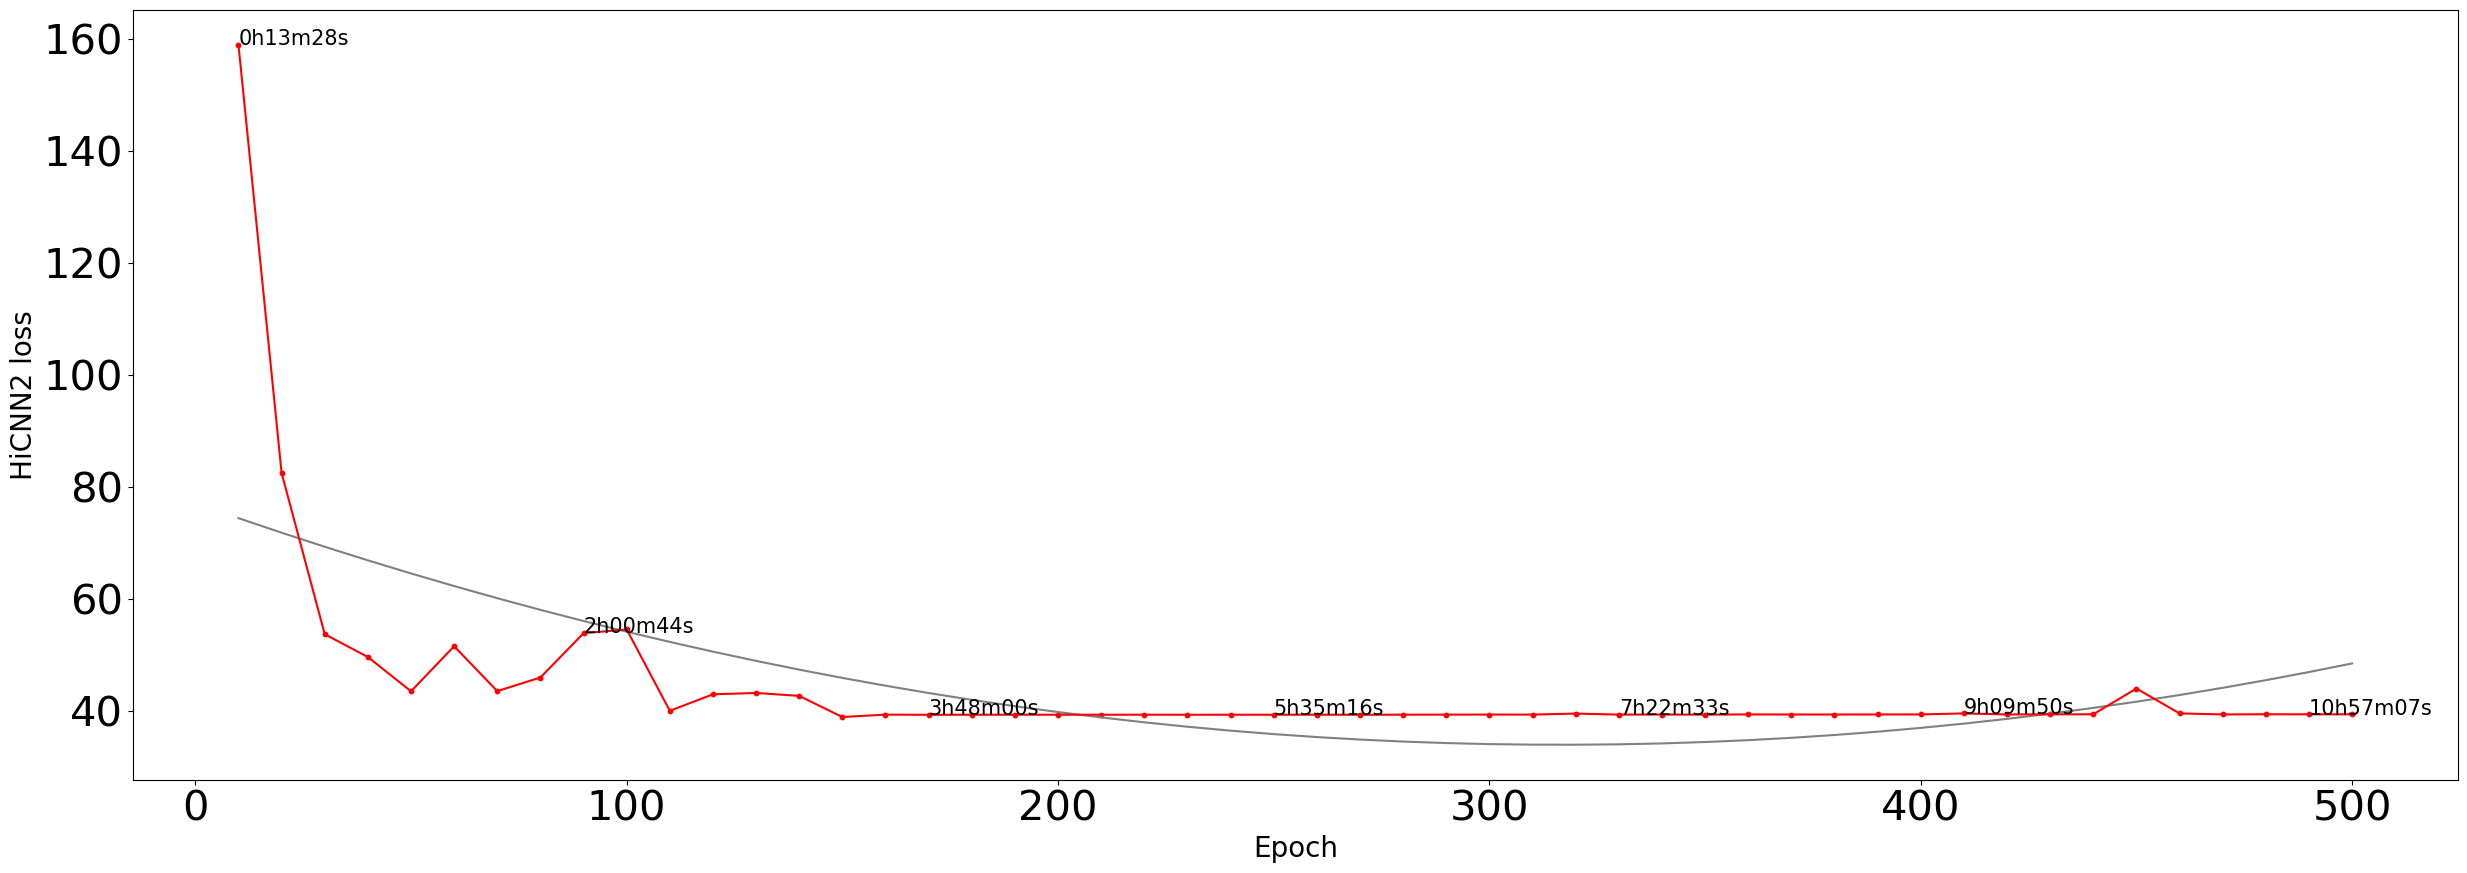

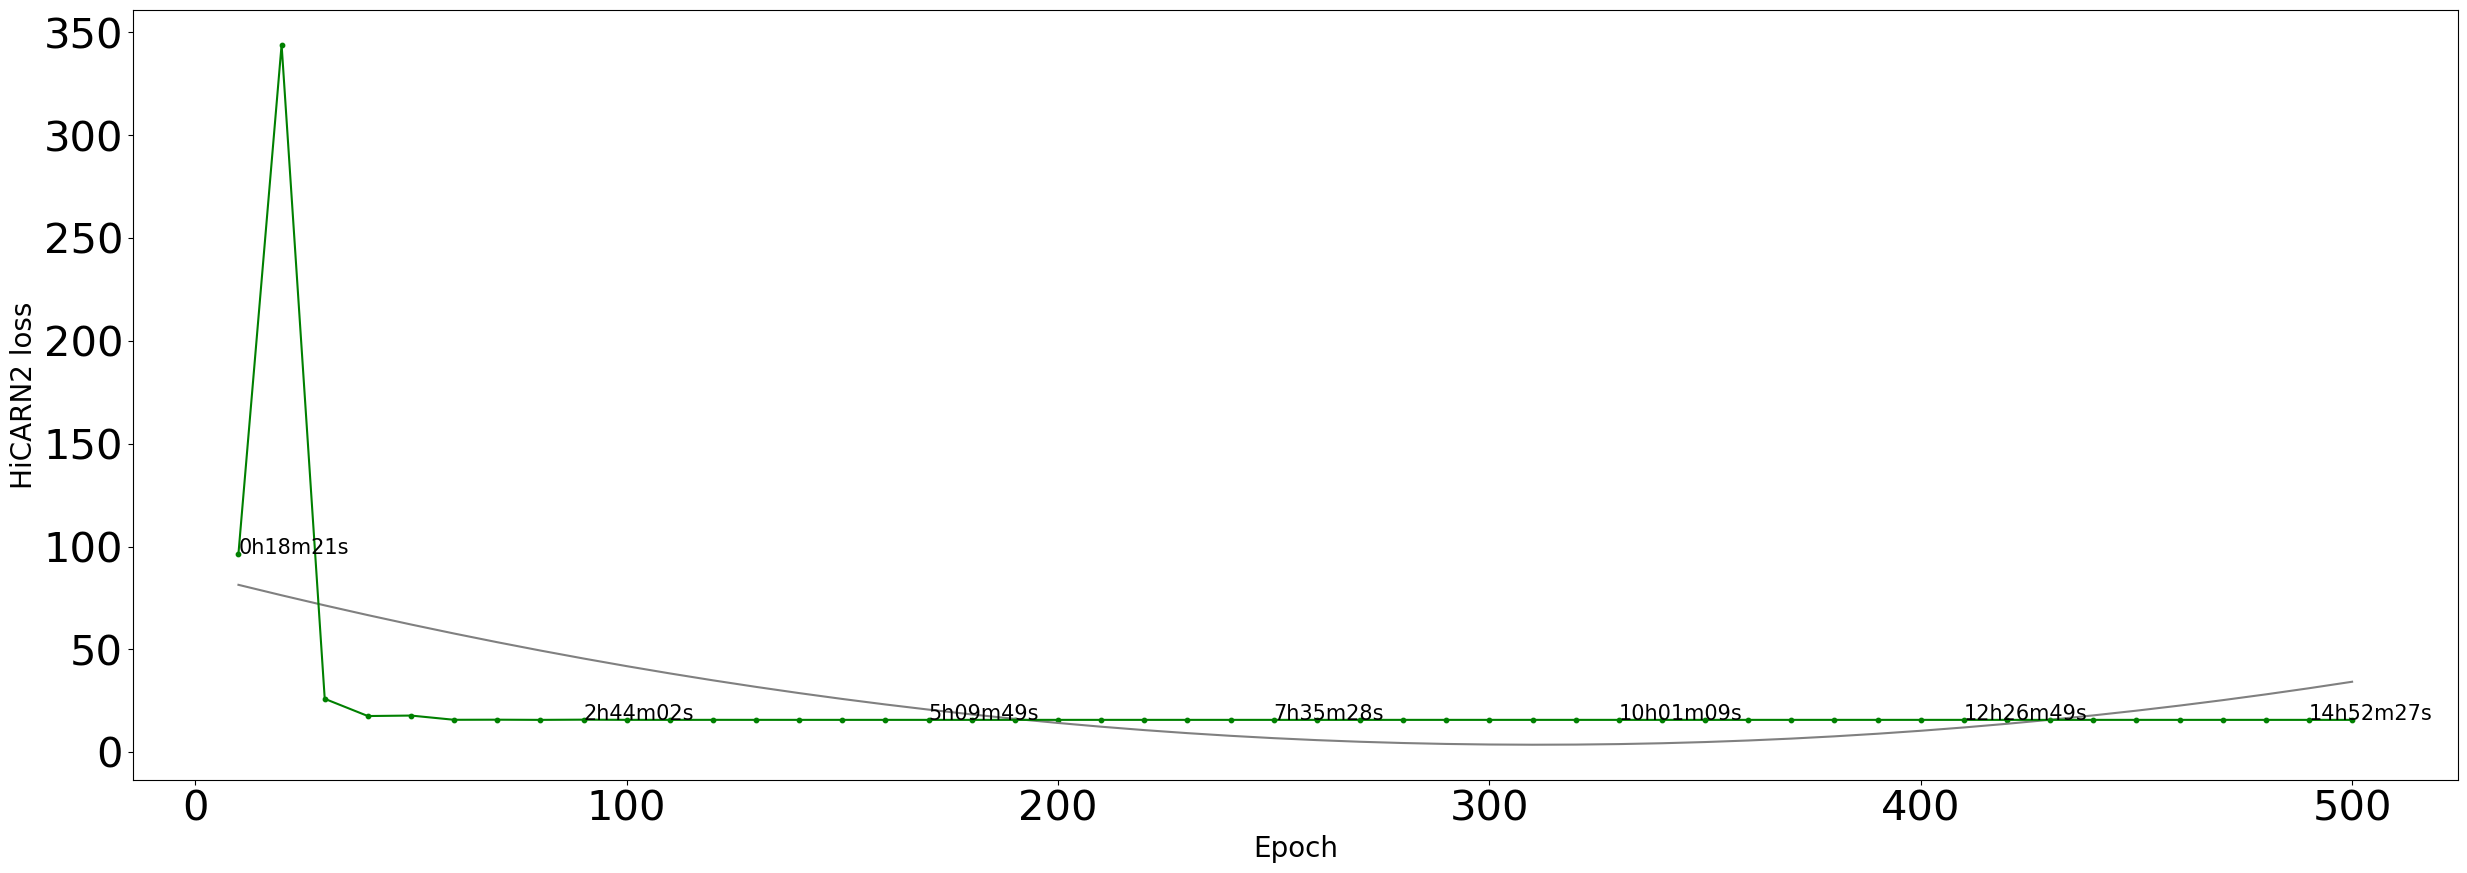

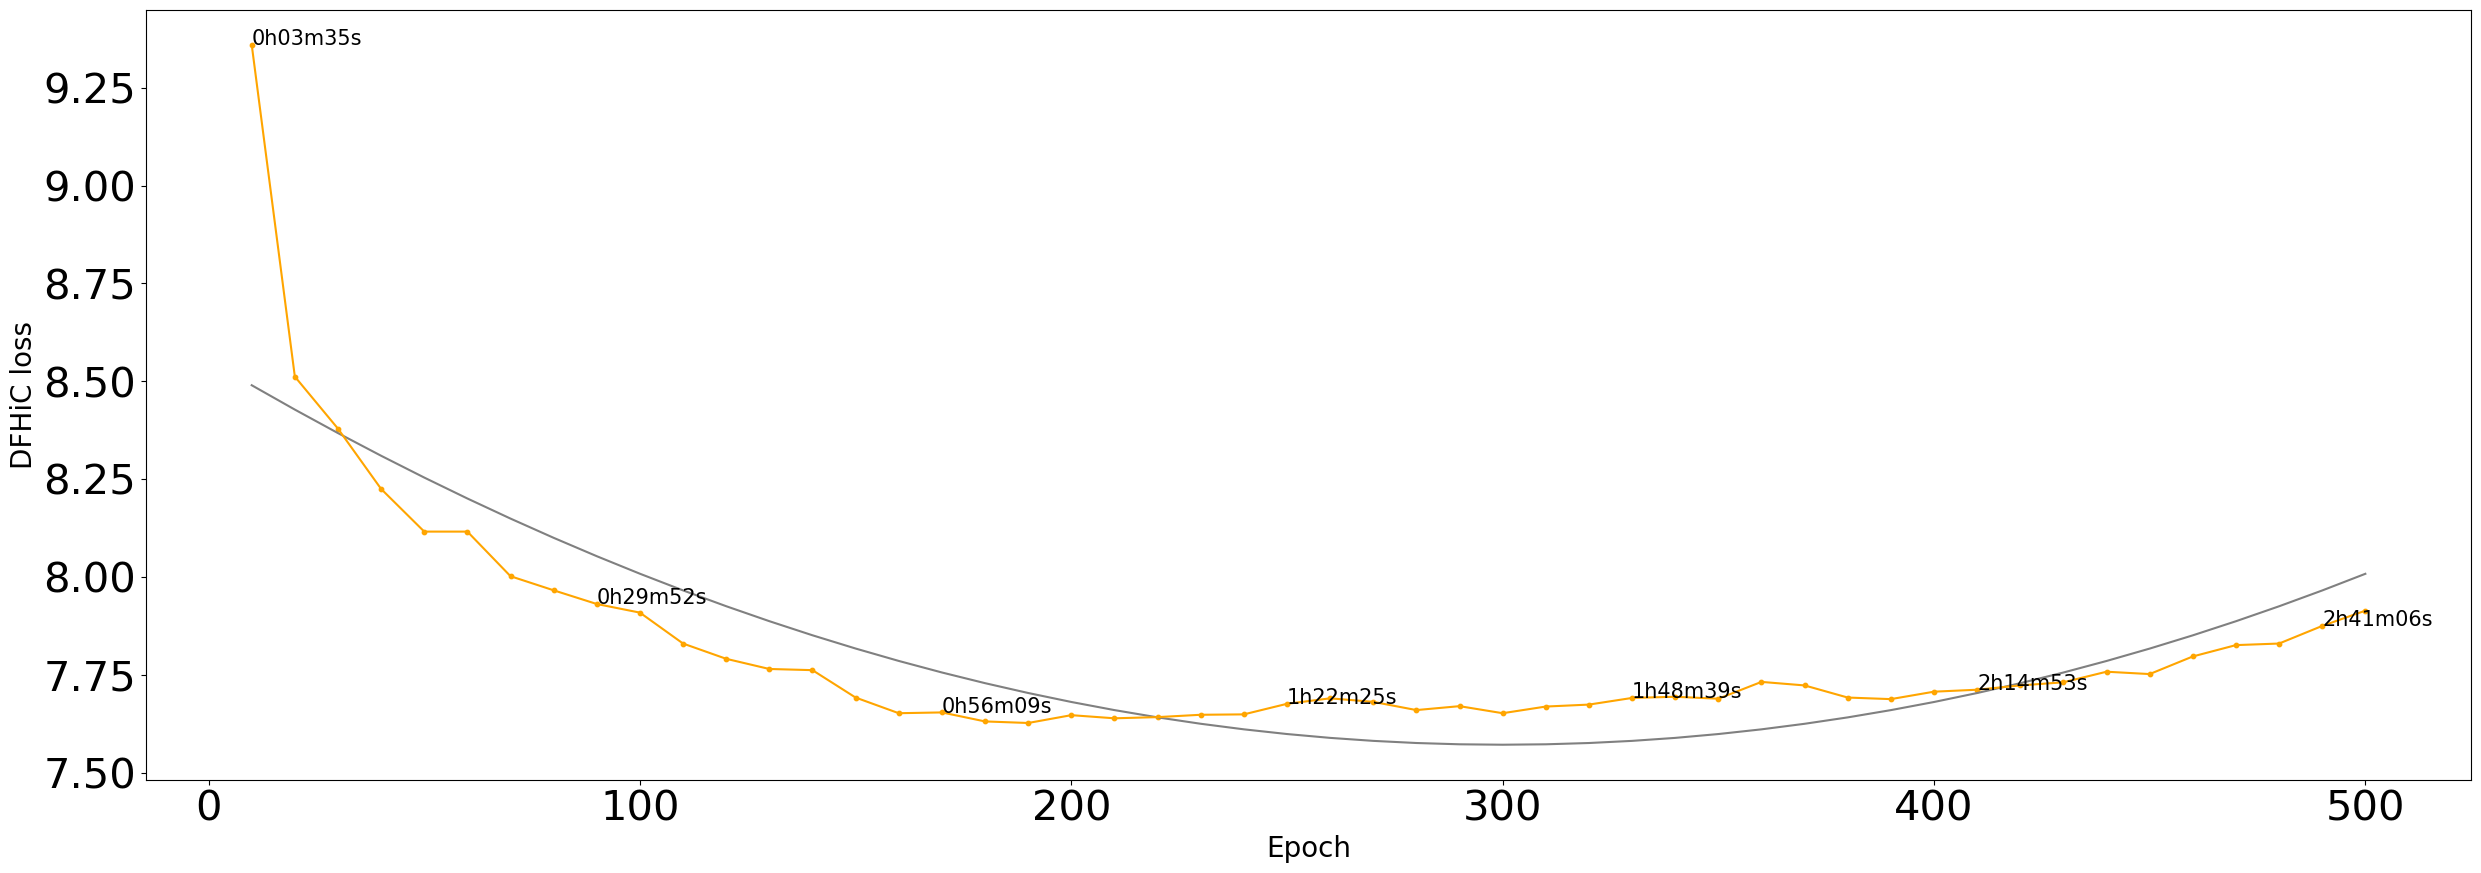

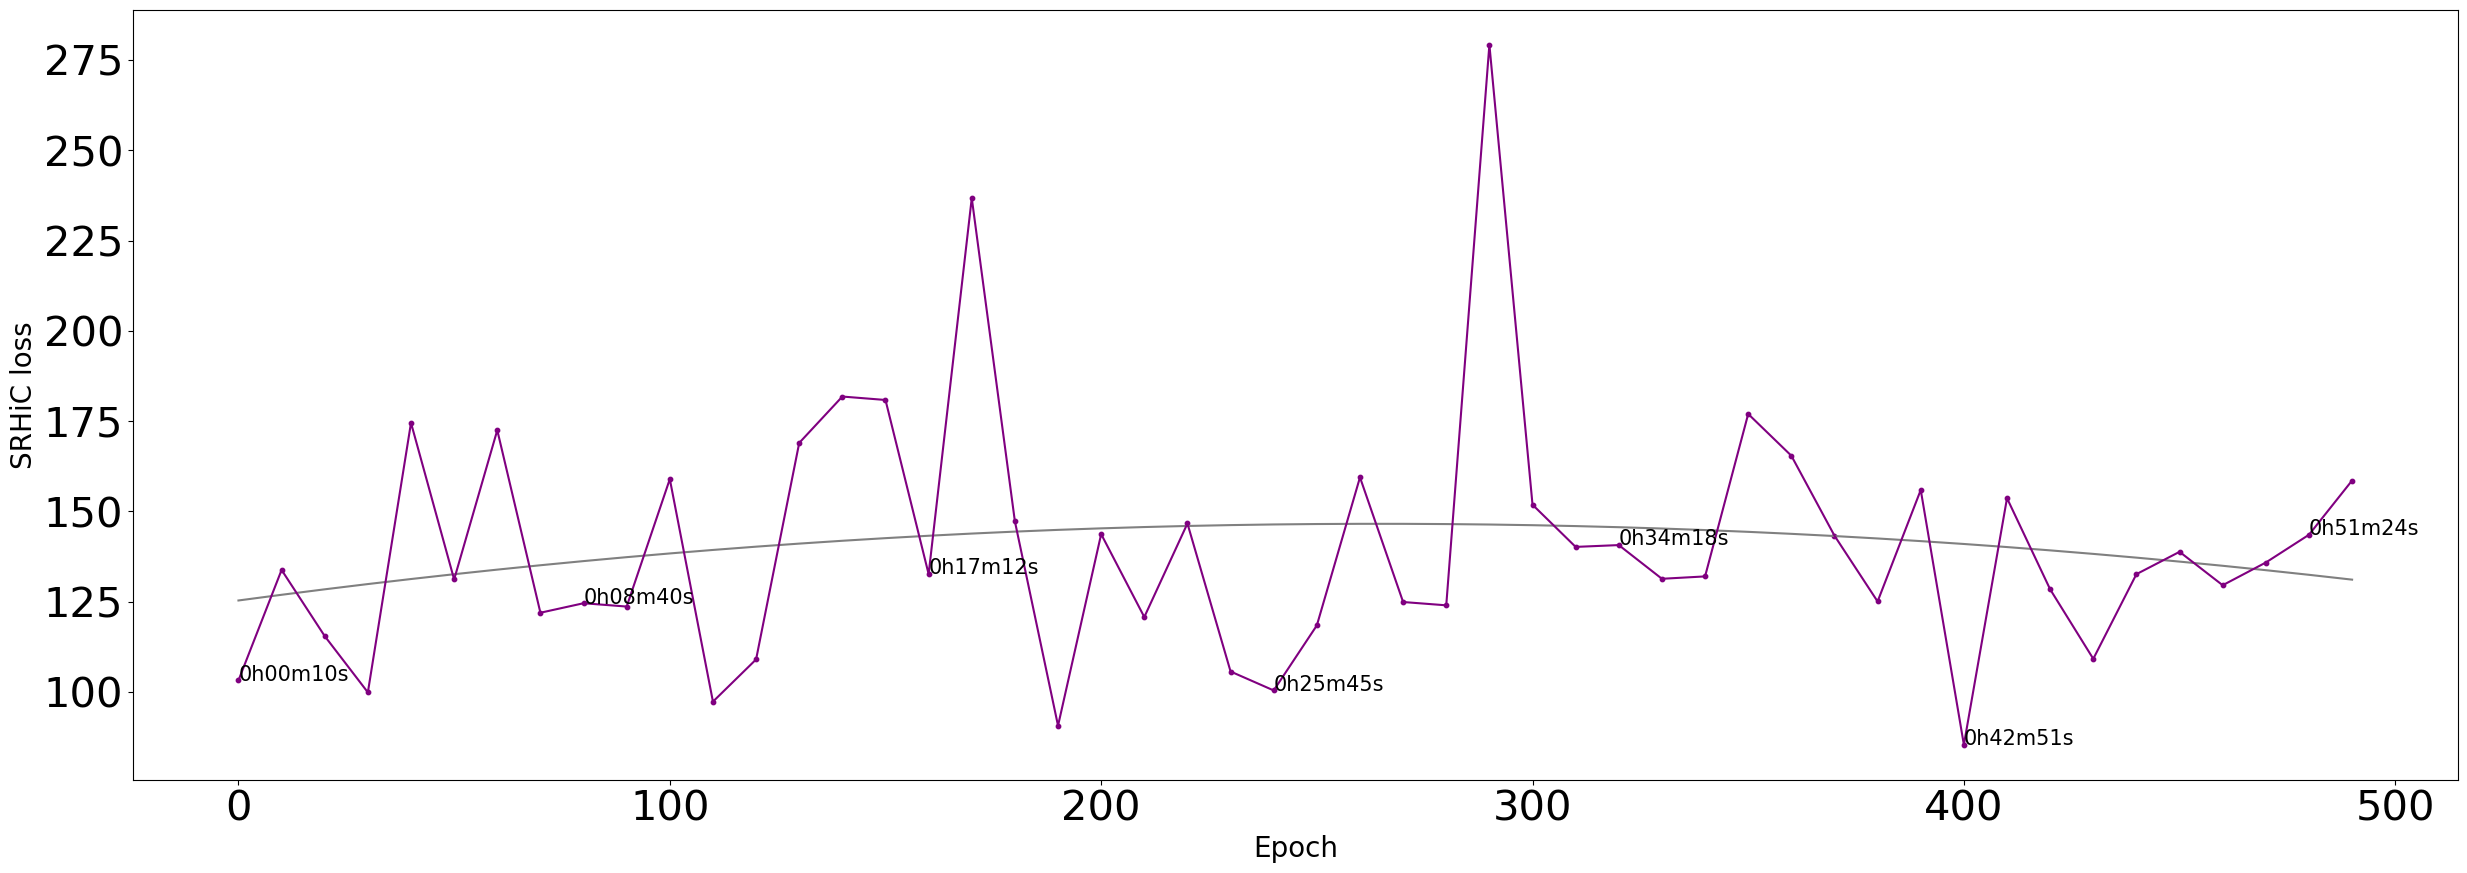

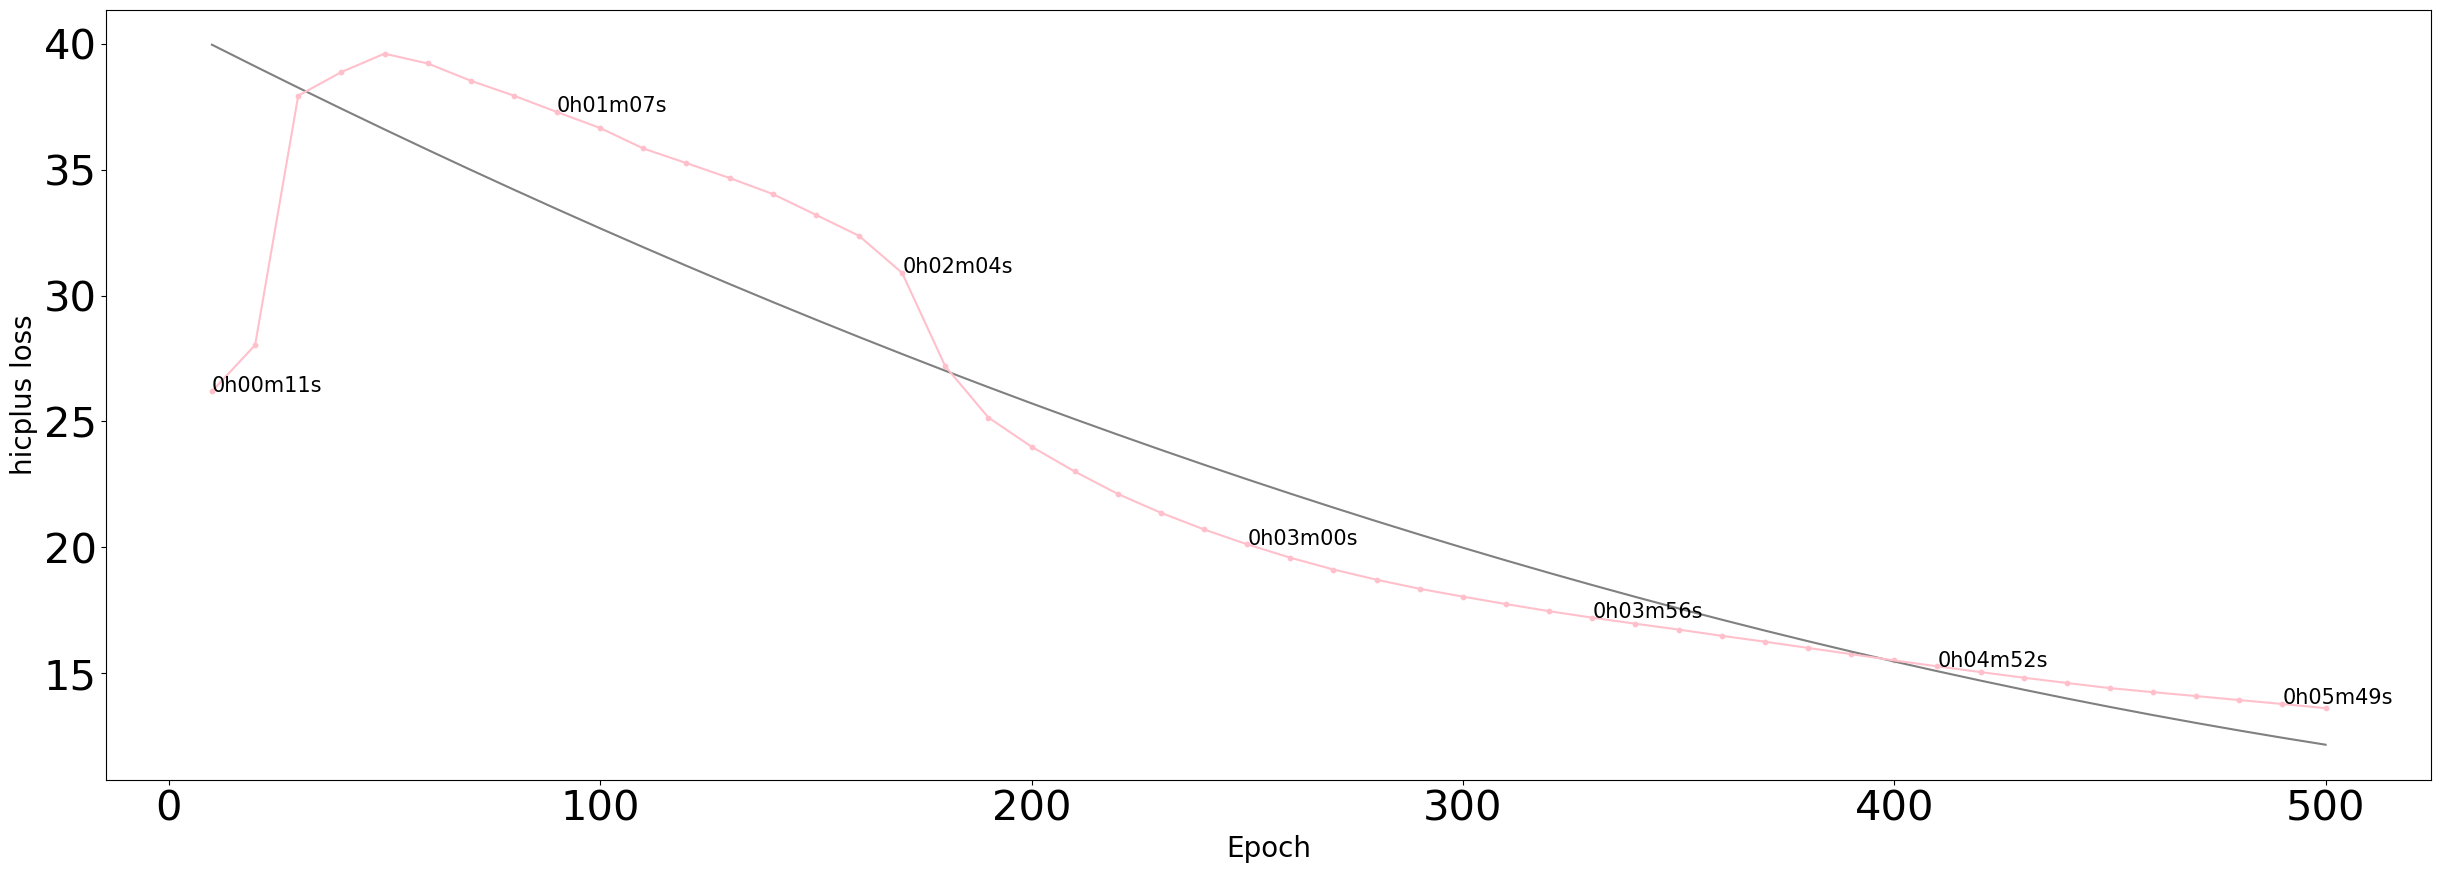

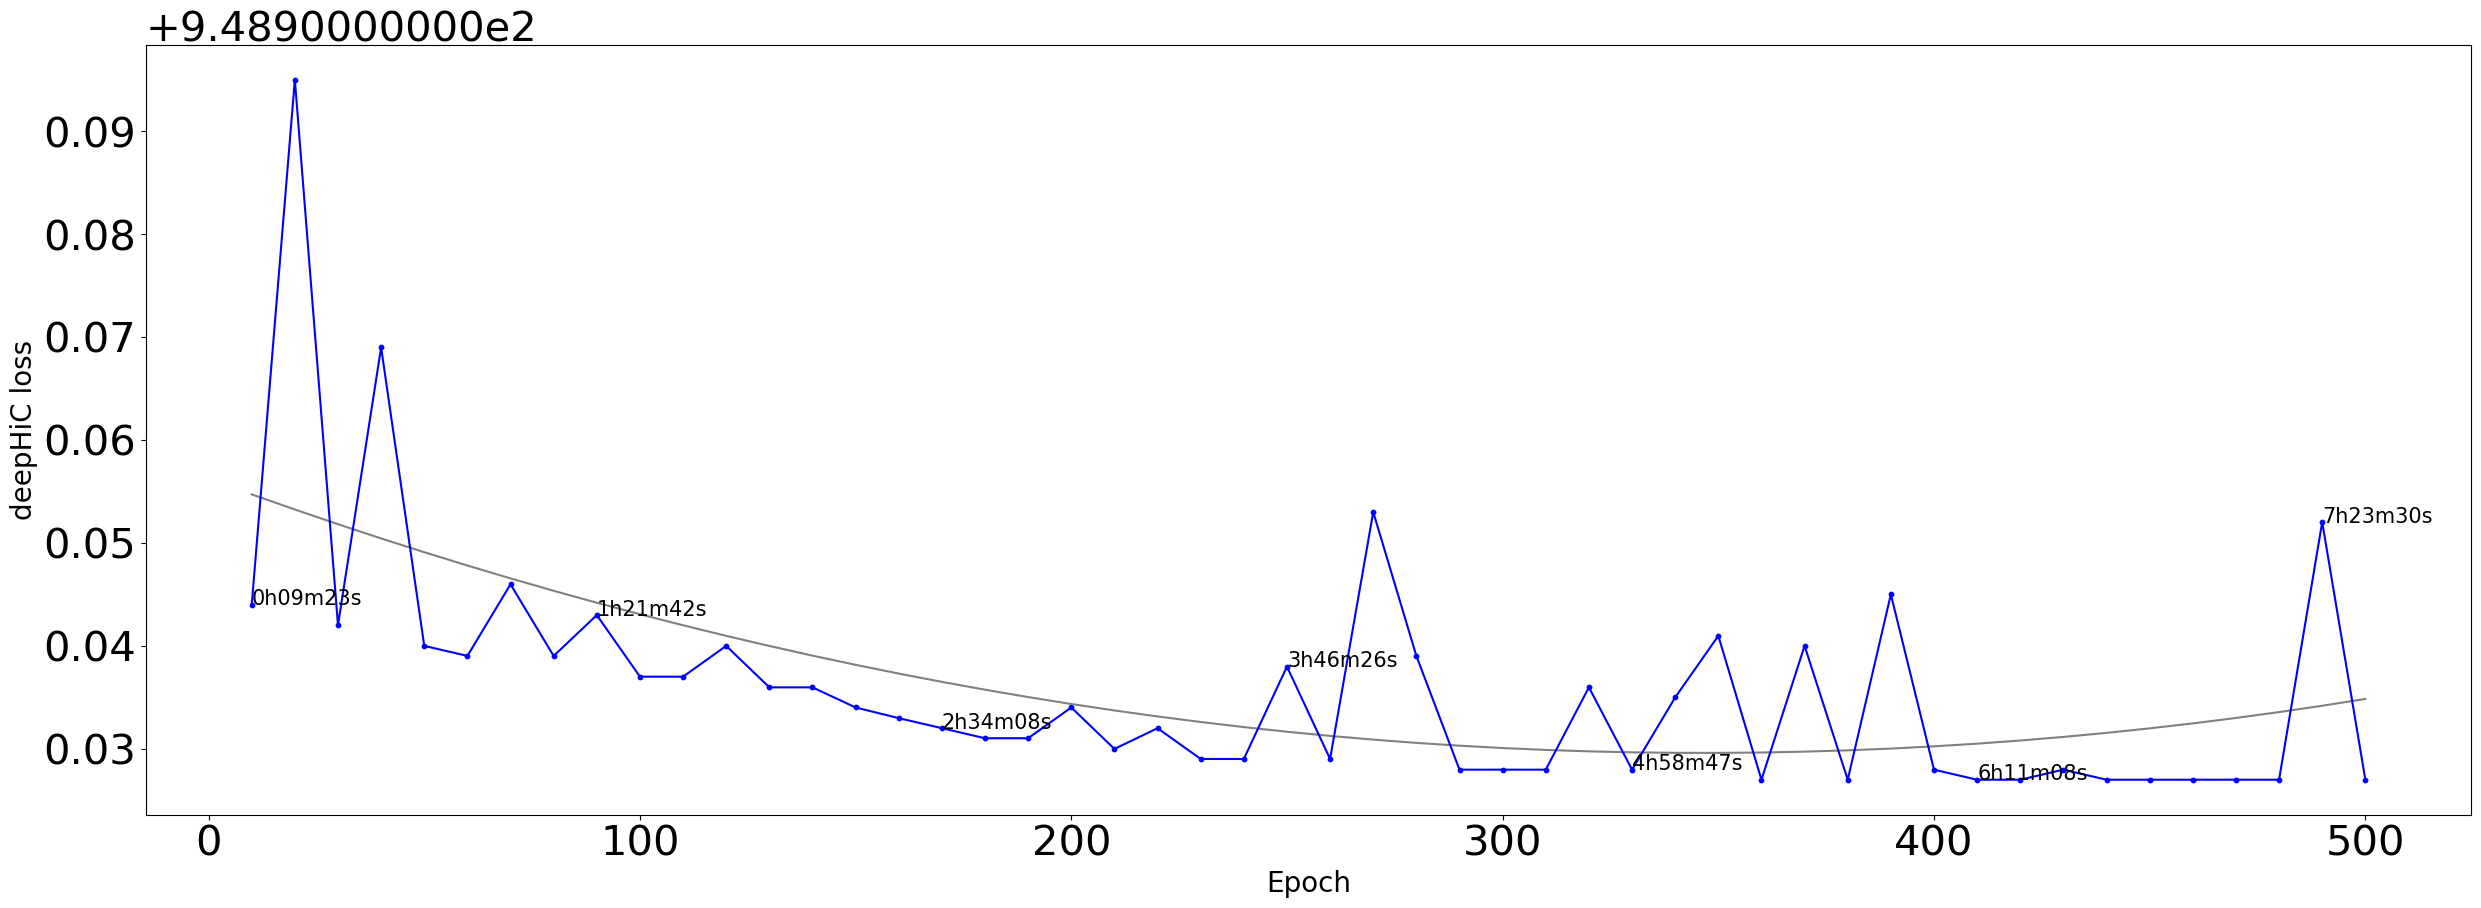

In [5]:
plt.rcParams.update({'font.size': 2})

for i, c, l in zip(['/data/HiHiC-main/log/train_loss_HiCNN2.npy',
                    '/data/HiHiC-main/log/train_loss_HiCARN2.npy',
                    '/data/HiHiC-main/log/train_loss_DFHiC.npy',
                    '/data/HiHiC-main/log/train_loss_SRHiC.npy',
                    '/data/HiHiC-main/log/train_loss_hicplus.npy',
                    '/data/HiHiC-main/log/train_loss_DeepHiC.npy'],
                    ['red', 'green', 'orange', 'purple', 'pink', 'blue'],
                    ['HiCNN2', 'HiCARN2', 'DFHiC', 'SRHiC', 'hicplus', 'deepHiC']):
    plt.figure(figsize=(30,10))
    i = np.load(i)
    x = i[0][:50].astype(np.int32)
    y = i[2][:50].astype(np.float32)
    plt.scatter(x,y, s=10, c=c)
    z = np.polyfit(x,y, 2)
    p = np.poly1d(z)
    plt.plot(x, p(x), color='gray')
    plt.plot(x, y, color=c, label=l)
    for i, (xx, yy, time) in enumerate(zip(x, y, i[1][:50])):
        if i%8 ==0:
            plt.text(xx, yy, time.replace('.','h', 1).replace('.', 'm', 1)+'s', fontsize="15")
    # plt.ylim([0.39, 0.42]) # [0.39, 0.42]
    plt.xlabel("Epoch", fontsize="20")
    plt.ylabel(l+" loss", fontsize="20")
    # plt.legend(fontsize="20")
    # plt.savefig('loss_trend.png')
    plt.show()

In [ ]:
def signaltonoise(Arr, axis=0, ddof=0):
    Arr = np.asanyarray(Arr)
    me = Arr.mean(axis)
    sd = Arr.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, me/sd)

Arr=[[20, 4, 7, 1, 34], [50, 12, 15, 34, 5]]
print(signaltonoise(Arr,axis=0,ddof=0))

In [ ]:
## version1
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 
  
def main(): 
     original = cv2.imread("original_image.png") 
     compressed = cv2.imread("compressed_image.png", 1) 
     value = PSNR(original, compressed) 
     print(f"PSNR value is {value} dB") 
     
     
## version2     
def calculate_psnr(img1, img2):
    # img1 and img2 have range [0, 255]
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))

In [ ]:
import math
import numpy as np
import cv2

def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(img1, img2):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

hicplus_predict_16.npz 
 ['data', 'inds'] 
 (2076, 1, 28, 28)


DFHiC_predicted_16.npz 
 ['arr_0'] 
 (2076, 40, 40, 1)


predict_chr19_16.npz 
 ['data', 'inds'] 
 (4081, 1, 40, 40)


predict_chr20_16.npz 
 ['data', 'inds'] 
 (4081, 1, 40, 40)


predict_chr21_16.npz 
 ['data', 'inds'] 
 (4081, 1, 40, 40)


HiCSR_test_ratio16.npy 
 (3952, 28, 28, 1)


predict_chr22_16.npz 
 ['data', 'inds'] 
 (4081, 1, 40, 40)


HiCNN2_predict_16.npz 
 ['data'] 
 (4081, 1, 28, 28)


predict_chr18_16.npz 
 ['data', 'inds'] 
 (4081, 1, 40, 40)




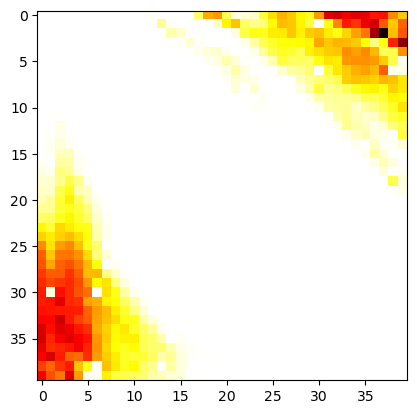

In [56]:
dir_path="/data/HiHiC-main/output"
output = os.listdir(dir_path)

for out in output:
    if out.endswith(".npz"):
        print(out, '\n', np.load(os.path.join(dir_path, out)).files, '\n', np.load(os.path.join(dir_path, out))[np.load(os.path.join(dir_path, out)).files[0]].shape)
        plt.imshow(np.load(os.path.join(dir_path, out))[np.load(os.path.join(dir_path, out)).files[0]][0,0], cmap='hot')
    else:
        print(out, '\n', np.load(os.path.join(dir_path, out)).shape)
        plt.imshow(np.load(os.path.join(dir_path, out))[0,0], cmap='hot')
    print("\n")

In [7]:
import numpy as np
import os
np.load("/data/HiHiC-main/data_SRHiC/train/train_ratio16.npy").shape

(33147, 40, 68)

In [9]:
np.load("/data/HiHiC-main/data_HiCNN/train/train_ratio16.npz")['data'].shape

(33147, 1, 40, 40)

In [84]:
dir_path="/data/HiHiC-main"
inputs = os.listdir(dir_path)

for input in inputs:
    if input.startswith("data_"):
        if not input.endswith(".py"):
            if not input.endswith(".sh"):
                if 'test' in os.listdir(os.path.join(dir_path,input)):
                    if os.listdir(os.path.join(dir_path, input, "test"))[0].endswith(".npz"):
                        print(input, "\n", np.load(os.path.join(dir_path, input, "test", os.listdir(os.path.join(dir_path, input, "test"))[0])).files)
                        print(np.load(os.path.join(dir_path, input, "test", os.listdir(os.path.join(dir_path, input, "test"))[0]))['data'].shape)
                    else:
                        print(input)#, "\n", np.load(os.path.join(dir_path, input, "test", os.listdir(os.path.join(dir_path, input, "test"))[0])).files)
                        print(np.load(os.path.join(dir_path, input, "test", os.listdir(os.path.join(dir_path, input, "test"))[0])).shape)
                    print("\n")

data_hicplus 
 ['data', 'target', 'inds', 'inds_target']
(2076, 1, 40, 40)


data_HiCNN 
 ['data', 'target', 'inds', 'inds_target']
(4081, 1, 40, 40)


data_DeepHiC 
 ['data', 'target', 'inds', 'compacts', 'size']
(2076, 1, 40, 40)


data_SRHiC
(3952, 40, 68)


data_HiCARN 
 ['data', 'target', 'inds', 'compacts', 'size']
(4081, 1, 40, 40)


data_DFHiC 
 ['data', 'target', 'distance']
(2076, 40, 40, 1)




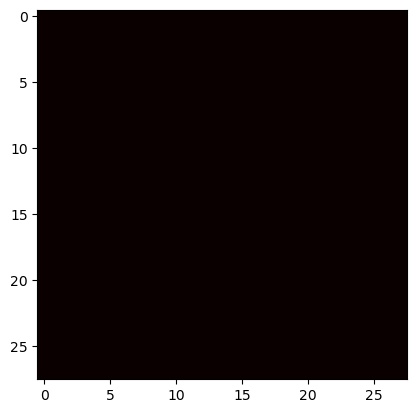

In [114]:
plt.imshow(np.load("/data/HiHiC-main/output/HiCSR_test_ratio16.npy")[0,:,:,0], cmap='hot')

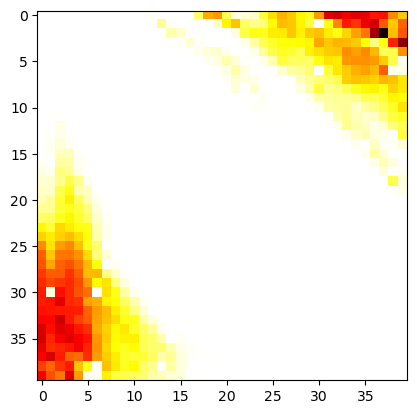

In [112]:
plt.imshow(np.load("/data/HiHiC-main/output/predict_chr22_16.npz")["data"][0,0], cmap='hot')

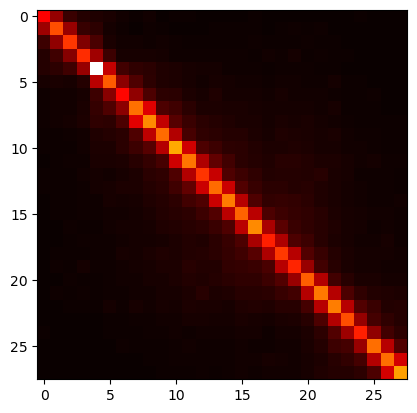

In [99]:
plt.imshow(np.load("/data/HiHiC-main/output/HiCNN2_predict_16.npz")["data"][0,0], cmap='hot')

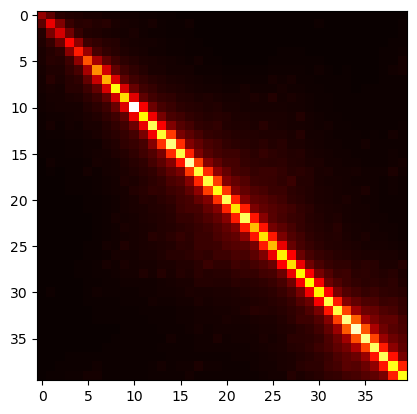

In [94]:
plt.imshow(np.load("/data/HiHiC-main/output/DFHiC_predicted_16.npz")["arr_0"][0,:,:,0], cmap='hot')
